In [1]:
import torch

from dataclasses import dataclass, field
from matplotlib import pyplot as plt
import numpy as np
import sys
from pprint import pprint
import pandas as pd

sys.path.append("../..")

# FLOPs of the mLSTM v1 & v2 blocks

In [21]:
%load_ext autoreload
%autoreload 2
from mlstm_kernels.flops_utils.flops_computation import (
    count_flops_mlstm_v1_block_fw,
    count_flops_mlstm_v2_block_fw,
    FLOPsComputation,
    count_fw_flops,
)
from mlstm_kernels.flops_utils.mlstm_block_flop_counts import (
    plot_mlstm_v1_v2_flop_comparison,
    make_flop_table,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
S = 8192
d = 4096
Nh = 8
chunk_size = 64

In [4]:
total_flops_v1, linear_layer_flops_v1, mlstm_flops_v1 = count_flops_mlstm_v1_block_fw(
    S=S, d=d, Nh=Nh, dqk=d // Nh, dv=d // Nh, chunk_size=chunk_size
)

In [5]:
pf = 2
total_flops_v2, linear_layer_flops_v2, mlstm_flops_v2 = count_flops_mlstm_v2_block_fw(
    S=S, d=d, Nh=Nh, pf=pf, dqk=(d * pf) // Nh, dv=(d * pf) // Nh, chunk_size=chunk_size
)

In [6]:
pf = 2
_, detailed_flops = count_flops_mlstm_v2_block_fw(
    S=S,
    d=d,
    Nh=Nh,
    pf=pf,
    dqk=(d * pf) // Nh,
    dv=(d * pf) // Nh,
    chunk_size=chunk_size,
    return_detailed_flops=True,
)
detailed_flops

{'linear_layer_flops': 1649334550528,
 'qkv_proj_flops': 1610612736,
 'conv1d_flops': 671285248,
 'skip_ln_mlstm_flops': 201359360,
 'skip_ln_linear_layer_flops': 33570816,
 'mlstm_cell_total_flops': 226001065984,
 'mlstm_cell_fw_C_flops': 208777057280,
 'mlstm_cell_fw_H_flops': 17224008704}

In [7]:
print(
    f"v2 linear_layer fraction: {detailed_flops['linear_layer_flops']/total_flops_v2}"
)
print(f"v2 qkv proj fraction: {detailed_flops['qkv_proj_flops']/total_flops_v2}")
print(f"v2 conv1d fraction: {detailed_flops['conv1d_flops']/total_flops_v2}")
print(f"v2 mlstm fraction: {detailed_flops['mlstm_cell_total_flops']/total_flops_v2}")

v2 linear_layer fraction: 0.8783089188970251
v2 qkv proj fraction: 0.0008576886541696954
v2 conv1d fraction: 0.0003574749708927486
v2 mlstm fraction: 0.12035081170793217


In [8]:
print(f"v1 mlstm fraction: {mlstm_flops_v1/total_flops_v1}")
print(f"v1 linear_layer fraction: {linear_layer_flops_v1/total_flops_v1}")

v1 mlstm fraction: 0.08317072311018933
v1 linear_layer fraction: 0.9168292768898106


In [9]:
print(
    f"Total FLOPS v1: {total_flops_v1/1e6}M, MLSTM FLOPS v1: {mlstm_flops_v1}, Linear Layer FLOPS v1: {linear_layer_flops_v1}"
)
print(
    f"Total FLOPS v2: {2*total_flops_v2/1e6}M, MLSTM FLOPS v2: {2*mlstm_flops_v2}, Linear Layer FLOPS v2: {2*linear_layer_flops_v2}"
)
# (2398691991552, 199500947456, 2199191044096)
# (3425595338752, 123637870592, 3298736242688)

Total FLOPS v1: 2398691.991552M, MLSTM FLOPS v1: 199500947456, Linear Layer FLOPS v1: 2199191044096
Total FLOPS v2: 3755704.889344M, MLSTM FLOPS v2: 453747421184, Linear Layer FLOPS v2: 3298736242688


In [10]:
print(f"Total Ratio v2/v1: {(2*total_flops_v2)/total_flops_v1}")
print(f"MLSTM Ratio v2/v1: {(2*mlstm_flops_v2)/mlstm_flops_v1}")
print(f"Linear Layer Ratio v2/v1: {(2*linear_layer_flops_v2)/linear_layer_flops_v1}")

Total Ratio v2/v1: 1.5657303657873918
MLSTM Ratio v2/v1: 2.2744123622975483
Linear Layer Ratio v2/v1: 1.4999771172876795


## FLOPs vs Model size


In [23]:
from mlstm_kernels.flops_utils.mlstm_block_flop_counts import (
    get_mlstm_v1_fw_flops,
    get_mlstm_v2_fw_flops,
    get_mlstm_v1_fw_7B_flops,
    get_mlstm_v2_fw_7B_flops,
)

In [12]:
sequence_length = 8192
batch_size = 1
chunk_size = 64

In [13]:
mlstm_flops_v1 = get_mlstm_v1_fw_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)
mlstm_flops_v2 = get_mlstm_v2_fw_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)

In [14]:
(
    mlstm_flops_v1["7B"].total_flops,
    mlstm_flops_v1["7B"].mlstm_other_flops,
    mlstm_flops_v1["7B"].linear_layer_flops,
)

(2398691991552, 199500947456, 2199191044096)

In [15]:
(
    mlstm_flops_v2["7B"].total_flops,
    mlstm_flops_v2["7B"].mlstm_other_flops,
    mlstm_flops_v2["7B"].linear_layer_flops,
)

(3755704889344, 453747421184, 3298736242688)

In [16]:
model_size_keys = list(mlstm_flops_v1.keys())

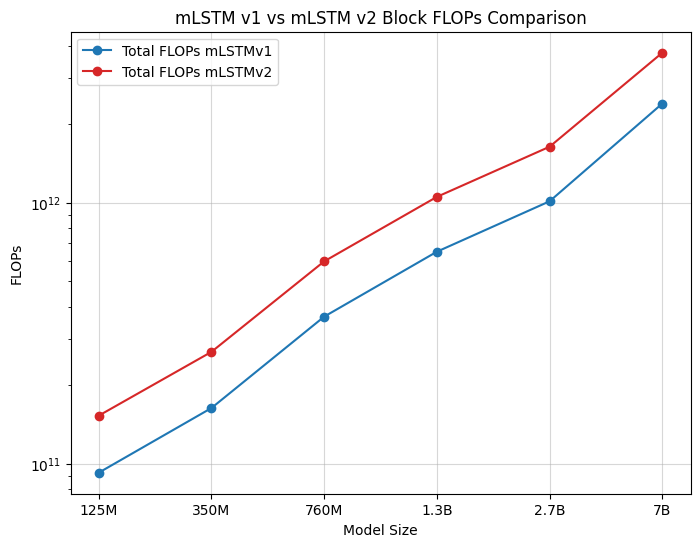

In [ ]:
fig = plot_mlstm_v1_v2_flop_comparison(
    sequence_length=8192, batch_size=1, chunk_size=64, model_size_keys=model_size_keys
)

In [22]:
mlstm_flops_v1 = get_mlstm_v1_fw_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)
mlstm_flops_v2 = get_mlstm_v2_fw_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)
make_flop_table(
    mlstm_flops_v1=mlstm_flops_v1,
    mlstm_flops_v2=mlstm_flops_v2,
    model_size_keys=model_size_keys,
)

,Model Size,Total FLOPs v1,Total FLOPs v2,v2/v1 Ratio,v1 Linear Layer FLOPs Ratio,v2 Linear Layer FLOPs Ratio,v1 MLSTM Other FLOPs Ratio,v2 MLSTM Other FLOPs Ratio
0,125M,92453267200,152889589760,1.653696,0.836540,0.758730,0.163460,0.237320
1,350M,163545706496,268396689408,1.641111,0.840627,0.768298,0.159373,0.228701
2,760M,366153728512,596248979456,1.628412,0.844729,0.778084,0.155271,0.219890
3,1.3B,649325941760,1053218723840,1.622019,0.846785,0.783061,0.153215,0.215410
4,2.7B,1013062346240,1639305922560,1.618169,0.848021,0.786074,0.151979,0.212698
5,7B,2398691991552,3755704889344,1.565730,0.916829,0.878327,0.083171,0.120816


In [25]:
mlstm_flops_v1_7B = get_mlstm_v1_fw_7B_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)
mlstm_flops_v2_7B = get_mlstm_v2_fw_7B_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)
make_flop_table(
    mlstm_flops_v1=mlstm_flops_v1_7B,
    mlstm_flops_v2=mlstm_flops_v2_7B,
    model_size_keys=mlstm_flops_v1_7B.keys(),
)

,Model Size,Total FLOPs v1,Total FLOPs v2,v2/v1 Ratio,v1 Linear Layer FLOPs Ratio,v2 Linear Layer FLOPs Ratio,v1 MLSTM Other FLOPs Ratio,v2 MLSTM Other FLOPs Ratio
0,7B_nh1,3724380312320,6671909856768,1.791415,0.590485,0.494422,0.409515,0.505096
1,7B_nh2,2966424798720,5005473664000,1.687376,0.741361,0.659026,0.258639,0.340331
2,7B_nh4,2587656707072,4172272244736,1.612375,0.849877,0.790633,0.150123,0.208595
3,7B_nh8,2398691991552,3755704889344,1.565730,0.916829,0.878327,0.083171,0.120816
4,7B_nh16,2305048294400,3547487920128,1.539008,0.954076,0.929879,0.045924,0.069212
